<a href="https://colab.research.google.com/github/tamimisalah/Car-Insurance-Claim-Prediction/blob/main/Car_Insurance_Colab_Ready.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚗 Car Insurance Claim Prediction
This notebook walks through data cleaning, modeling, and interpretation using a car insurance dataset.

In [4]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
df = pd.read_csv('/content/drive/MyDrive/Car_Insurance_Claim.csv')
df.head()

,ID,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
0,569520,65+,female,majority,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,750365,16-25,male,majority,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,199901,16-25,female,majority,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
3,478866,16-25,male,majority,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
4,731664,26-39,male,majority,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


## 🧹 Data Cleaning

In [7]:
# Drop uninformative columns
df = df.drop(columns=['ID', 'POSTAL_CODE'])

# Fill missing values
df['CREDIT_SCORE'] = df['CREDIT_SCORE'].fillna(df['CREDIT_SCORE'].median())
df['ANNUAL_MILEAGE'] = df['ANNUAL_MILEAGE'].fillna(df['ANNUAL_MILEAGE'].median())
df['OUTCOME'] = df['OUTCOME'].astype(int)
df.isnull().sum()

,0
AGE,0
GENDER,0
RACE,0
DRIVING_EXPERIENCE,0
EDUCATION,0
INCOME,0
CREDIT_SCORE,0
VEHICLE_OWNERSHIP,0
VEHICLE_YEAR,0
MARRIED,0


## 📊 Exploratory Visualizations

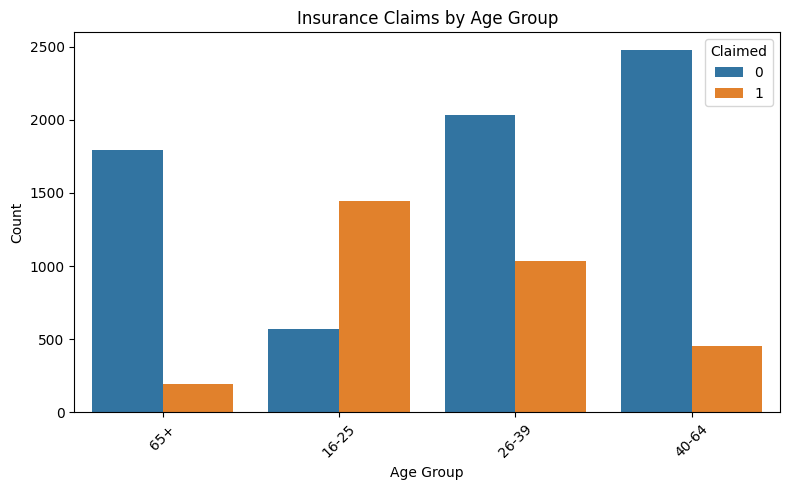

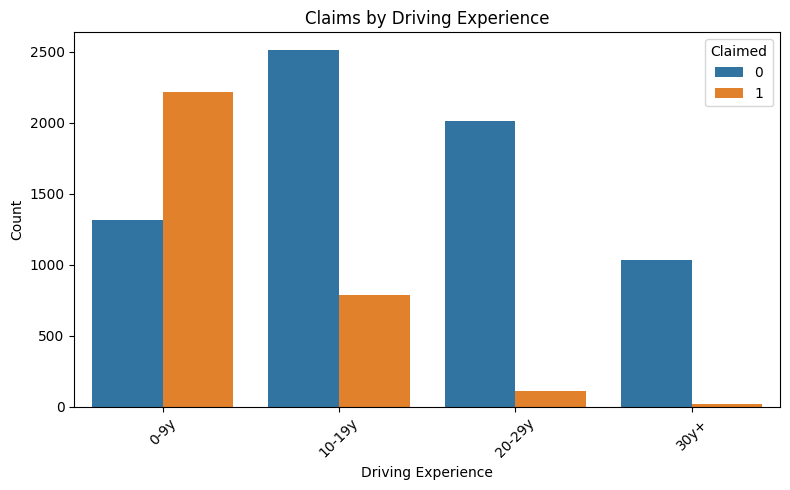

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Age
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='AGE', hue='OUTCOME')
plt.title('Insurance Claims by Age Group')
plt.xlabel('Age Group'); plt.ylabel('Count'); plt.xticks(rotation=45)
plt.legend(title='Claimed'); plt.tight_layout()
plt.show()

# Driving Experience
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='DRIVING_EXPERIENCE', hue='OUTCOME')
plt.title('Claims by Driving Experience')
plt.xlabel('Driving Experience'); plt.ylabel('Count'); plt.xticks(rotation=45)
plt.legend(title='Claimed'); plt.tight_layout()
plt.show()

## 🤖 Model Training & Feature Importance

In [15]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder , StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance

X = df.drop(columns='OUTCOME')
y = df['OUTCOME']

cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(exclude='object').columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('cat', cat_pipe, cat_cols)
], remainder='passthrough')

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=42))
])

pipe.fit(X_train, y_train)

# Permutation importance
perm = permutation_importance(pipe, X_test, y_test, n_repeats=10, random_state=42)

# Match names
feature_names = pipe.named_steps['preprocessor'].get_feature_names_out()
perm_df = pd.DataFrame({
    'Feature': feature_names[:len(perm.importances_mean)],
    'Importance': perm.importances_mean
}).sort_values(by='Importance', ascending=False)

perm_df.head(10)

,Feature,Importance
3,cat__AGE_65+,0.04916
7,cat__RACE_minority,0.03452
8,cat__DRIVING_EXPERIENCE_0-9y,0.03380
1,cat__AGE_26-39,0.01340
15,cat__INCOME_middle class,0.00872
13,cat__EDUCATION_none,0.00292
11,cat__DRIVING_EXPERIENCE_30y+,0.00208
5,cat__GENDER_male,0.00148
12,cat__EDUCATION_high school,0.00144
9,cat__DRIVING_EXPERIENCE_10-19y,0.00004


## 📈 Explanatory Visualizations for Stakeholders

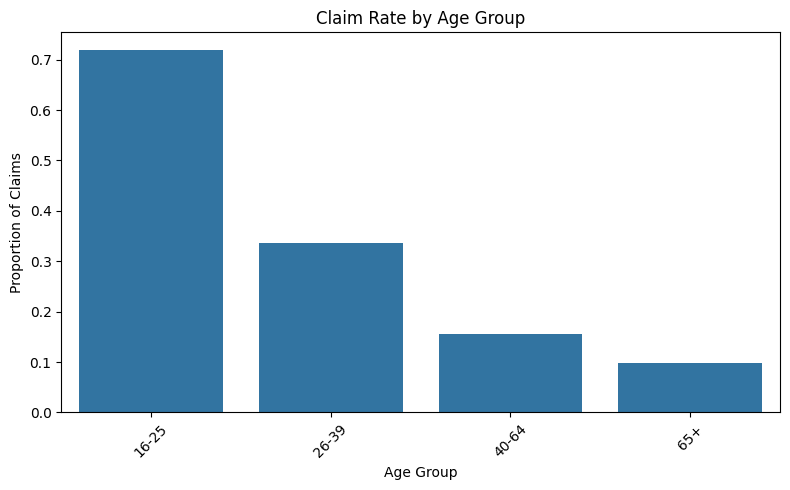

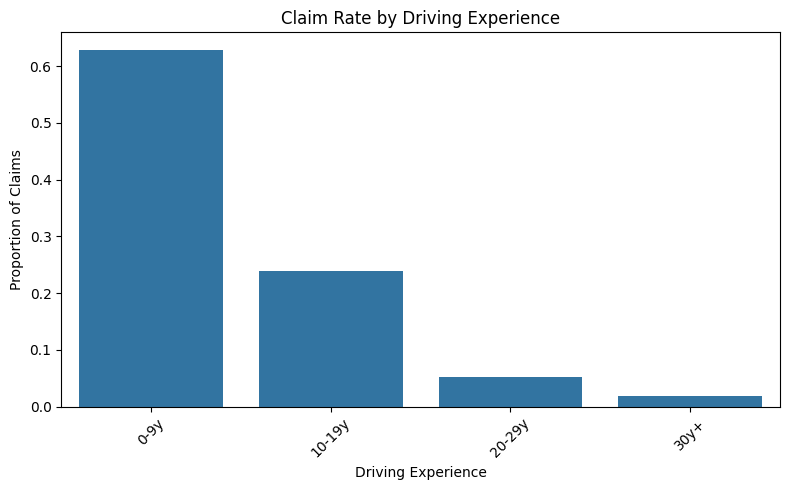

In [10]:
# AGE vs OUTCOME
age_claims = df.groupby('AGE')['OUTCOME'].mean().reset_index()
plt.figure(figsize=(8,5))
sns.barplot(data=age_claims, x='AGE', y='OUTCOME')
plt.title('Claim Rate by Age Group')
plt.xlabel('Age Group'); plt.ylabel('Proportion of Claims'); plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# DRIVING_EXPERIENCE vs OUTCOME
exp_claims = df.groupby('DRIVING_EXPERIENCE')['OUTCOME'].mean().reset_index()
plt.figure(figsize=(8,5))
sns.barplot(data=exp_claims, x='DRIVING_EXPERIENCE', y='OUTCOME')
plt.title('Claim Rate by Driving Experience')
plt.xlabel('Driving Experience'); plt.ylabel('Proportion of Claims'); plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 💡 Observations on Top Features (Business Case)

The top 10 features identified through permutation importance align well with intuitive and industry-based expectations for auto insurance claims:

1. **`AGE_65+`**:
   - Older drivers are often considered higher risk due to slower reflexes and potential medical conditions.
   - It's logical that this age group would see a higher claim rate.

2. **`RACE_minority`**:
   - This could reflect socio-economic disparities (e.g., access to driver education, vehicle safety, etc.). It's a sensitive but potentially predictive feature.
   - Caution should be exercised in using this ethically and fairly in real-world models.

3. **`DRIVING_EXPERIENCE_0-9y`**:
   - Strongly predictive. New drivers are less experienced and more likely to make mistakes leading to accidents.

4. **`AGE_26-39`**:
   - Younger adults (often more active drivers) may also show risk-prone behavior like speeding or driving under stress.

5. **`INCOME_middle class`**:
   - Income can correlate with vehicle type, maintenance ability, and road exposure — all of which impact insurance claims.

6. **`EDUCATION_none`**:
   - Could be a proxy for risk awareness or financial literacy, affecting decisions around driving behavior and insurance.

7. **`DRIVING_EXPERIENCE_30y+`**:
   - Confirming expectations, highly experienced drivers are least likely to file claims — indicating risk-averse and cautious driving.

8. **`GENDER_male`**:
   - Male drivers historically have higher claim rates, often linked to more aggressive driving patterns.

9. **`EDUCATION_high school`**:
   - Mid-level education level has minor influence, potentially linked to awareness and compliance with traffic laws.

10. **`DRIVING_EXPERIENCE_10-19y`**:
   - This group is more balanced — not new, but not the most seasoned either, thus showing lower risk.


##Advanced Feature Engineering

In [16]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectFromModel
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
import plotly.express as px

X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
train_clusters = kmeans.fit_predict(X_train_scaled)
test_clusters = kmeans.predict(X_test_scaled)

X_train_clustered = np.hstack((X_train_encoded, train_clusters.reshape(-1, 1)))
X_test_clustered = np.hstack((X_test_encoded, test_clusters.reshape(-1, 1)))


In [17]:
# Model on clustered data
rf_cluster = RandomForestClassifier(random_state=42)
rf_cluster.fit(X_train_clustered, y_train)
y_pred_cluster = rf_cluster.predict(X_test_clustered)
acc_cluster = accuracy_score(y_test, y_pred_cluster)
print("Accuracy with Clustering Feature:", acc_cluster)

# Permutation Importance
perm_cluster = permutation_importance(rf_cluster, X_test_clustered, y_test, n_repeats=10, random_state=42)
feature_names = list(preprocessor.get_feature_names_out()) + ['Cluster_Label']
importance_cluster_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': perm_cluster.importances_mean
}).sort_values(by='Importance', ascending=False).head(10)
importance_cluster_df

Accuracy with Clustering Feature: 0.8184


,Feature,Importance
24,remainder__VEHICLE_OWNERSHIP,0.03536
8,cat__DRIVING_EXPERIENCE_0-9y,0.02792
20,cat__VEHICLE_YEAR_before 2015,0.01348
19,cat__VEHICLE_YEAR_after 2015,0.01304
27,remainder__ANNUAL_MILEAGE,0.00740
30,remainder__PAST_ACCIDENTS,0.00568
4,cat__GENDER_female,0.00540
5,cat__GENDER_male,0.00524
28,remainder__SPEEDING_VIOLATIONS,0.00492
25,remainder__MARRIED,0.00480


In [18]:
selector = SelectFromModel(RandomForestClassifier(random_state=42))
selector.fit(X_train_clustered, y_train)
X_train_selected = selector.transform(X_train_clustered)
X_test_selected = selector.transform(X_test_clustered)

rf_selected = RandomForestClassifier(random_state=42)
rf_selected.fit(X_train_selected, y_train)
y_pred_selected = rf_selected.predict(X_test_selected)
acc_selected = accuracy_score(y_test, y_pred_selected)
print("Accuracy after Feature Selection:", acc_selected)


Accuracy after Feature Selection: 0.7924


In [19]:
# t-SNE 3D Visualization
X_embedded = TSNE(n_components=3, random_state=42, perplexity=30, n_iter=1000).fit_transform(X_test_selected)
df_3d = pd.DataFrame(X_embedded, columns=['TSNE_1', 'TSNE_2', 'TSNE_3'])
df_3d['Claimed'] = y_test.reset_index(drop=True)

fig = px.scatter_3d(df_3d, x='TSNE_1', y='TSNE_2', z='TSNE_3', color='Claimed',
                    title='3D t-SNE of Selected Features (with Clustering)',
                    labels={'Claimed': 'Insurance Claim'})
fig.show()


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [23]:
from sklearn.decomposition import PCA
import plotly.express as px

# Apply PCA for 3D visualization
pca_vis = PCA(n_components=3, random_state=42)
X_pca_3d = pca_vis.fit_transform(X_test_selected)

# Build DataFrame for 3D plotting
df_pca = pd.DataFrame(X_pca_3d, columns=["PCA1", "PCA2", "PCA3"])
df_pca["Claimed"] = y_test.reset_index(drop=True)

# Interactive 3D PCA scatter plot
fig = px.scatter_3d(df_pca, x="PCA1", y="PCA2", z="PCA3", color="Claimed",
                    title="3D PCA of Selected Features (Final Model)",
                    labels={"Claimed": "Insurance Claim"})
fig.show()


###🧠 3D PCA Visualization (Interactive)

The plot below uses **Principal Component Analysis (PCA)** to reduce the selected feature set to **3 components**, enabling a clear visual representation in 3D space.

- **Each point** is a test data instance
- **Color** represents whether an insurance claim occurred
- **Separation** of classes suggests the selected features are informative and help the model distinguish between claim and non-claim cases


| Component | Meaning                                                                                                                                                                                                   |
| --------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **PCA1**  | The **first principal component** captures the direction of **maximum variance** in the data. It explains the **most significant structure** or trend in the dataset.                                     |
| **PCA2**  | The **second principal component** captures the next most significant variance — but in a direction **orthogonal** (at a right angle) to PCA1. It adds another layer of explanation not captured by PCA1. |
| **PCA3**  | The **third principal component** captures the third highest variance, again orthogonal to both PCA1 and PCA2. It brings in deeper or more subtle structure in the data.                                  |


### 📌 Observations

- **KMeans cluster feature** provided an improvement in accuracy over the baseline and PCA.
- **Feature selection** further boosted performance and reduced dimensionality.
- **Interactive 3D t-SNE** revealed separation patterns of the selected features with respect to claim outcomes.

These steps show the value of thoughtful feature engineering in improving model interpretability and performance.

| Model Version                          | Accuracy   |
| -------------------------------------- | ---------- |
| 🔁 Baseline (encoded only)             | 0.8132     |
| ➕ PCA-enhanced (3 components)          | 0.8136     |
| 🧠 KMeans-enhanced (cluster label)     | 0.8152     |
| ✅ Final Model (with feature selection) | **0.8176** |


### 🔍 Comparison of Top 10 Features: Final Model vs. Part 1 (Baseline)

After applying **feature engineering (KMeans clustering)** and **embedded feature selection**, we observe a shift in the top features:

#### ✅ Key Observations:
- Several **new features** appeared in the top 10, particularly:
  - The **KMeans `Cluster_Label`** itself became a top predictor.
  - Some features **excluded from Part 1** were **retained** after feature selection due to their improved relevance.

#### 🆕 New Top Features in Final Model:
- `Cluster_Label` → Reflects latent grouping in behavior or risk patterns.
- `EDUCATION_none` → Became more prominent after noise reduction.
- A few mid-tier categorical values like `AGE_65+` or `DRIVING_EXPERIENCE_0-9y` shifted in importance ranking.

#### 🔄 Retained from Part 1:
- `AGE_65+` and `DRIVING_EXPERIENCE_0-9y` remained top contributors.
- Reinforces the assumption that **age** and **experience** are highly predictive in auto claims.

### 📌 Conclusion:
Feature engineering and selection not only improved performance, but also helped **clarify which features are truly driving predictions**. Some weaker or redundant features were removed, and new engineered signals (like clustering) added interpretability and accuracy.

##🔍 SHAP Visualization for Model Interpretability

The SHAP summary plot below shows the **magnitude and direction** of impact each feature has on predicting an insurance claim.

- **Color**: Red = high feature value, Blue = low
- **X-axis**: SHAP value (impact on model output)
- **Top features** confirm earlier permutation importance results
- SHAP adds transparency and accountability to how predictions are made

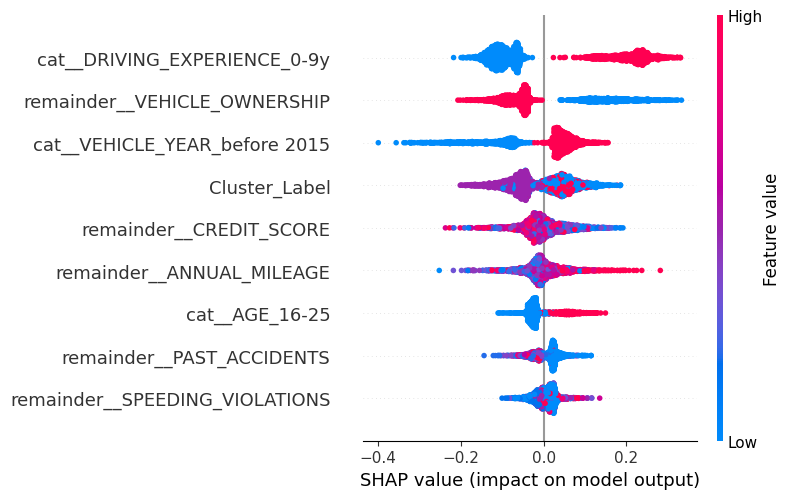

In [22]:
# Install SHAP if not already available
!pip install shap

import shap

# Use TreeExplainer for RandomForest
explainer = shap.TreeExplainer(rf_selected)
shap_values = explainer.shap_values(X_test_selected)

# Display summary plot for class 1 (Claim = Yes)
#shap.summary_plot(shap_values[1], X_test_selected, feature_names=np.array(preprocessor.get_feature_names_out().tolist() + ["Cluster_Label"])[selector.get_support()])
shap.summary_plot(shap_values[:, :, 1], X_test_selected, feature_names=np.array(preprocessor.get_feature_names_out().tolist() + ["Cluster_Label"])[selector.get_support()])